Anthéa Richaume - Maria Hattab

# Projet MADMC 2021–2022 : Élicitation incrémentale et recherche locale pour le problème du sac à dos multi-objectifs

## 2) Une première procédure de résolution

In [9]:
def readFile_DAT_full(fileName):
    """ Importation d'un problème SAD

    Parametres
    ----------
    fileName : string
        fichier DAT contenant un problème SAD
        
    Returns
    -------
    objets : liste
        liste de listes contenant le poids [0] et les critères d'un objet [1:n]
    tailleSAD : int
        la capacité W du SAD
    """
    objets = []
    tailleSAD = 0
    with open(fileName, "r") as txt_file:
        fichier = txt_file.readlines()
        tmp = []
        for ligne in fichier:
            if ligne[0] == "i":
                tmp = ligne.split()
                #objets.append((int(tmp[1])))
                obj = []
                for i in range(1, len(tmp)):
                    obj.append(int(tmp[i]))
                objets.append(obj)
            elif ligne[0] == "W":
                tmp = ligne.split()
                tailleSAD = int(tmp[1])
    return objets, tailleSAD

In [2]:
#vérification
a, b = readFile_DAT('2KP200-TA-0.dat')
for i in a:
    tmp = "objet"
    for j in range(len(i)):
        tmp += " " + str(i[j])
    print(tmp)
print("taille "+str(b))

objet 394 783 840 906 823 623 631
objet 911 198 798 820 509 443 987
objet 768 278 335 100 429 269 709
objet 477 629 554 933 862 375 133
objet 513 952 365 941 208 43 444
objet 636 717 916 493 460 572 635
objet 607 17 142 736 15 539 264
objet 138 804 243 318 232 37 815
objet 401 130 157 821 610 782 321
objet 998 219 109 181 509 214 959
objet 839 613 513 844 734 661 112
objet 637 524 296 23 757 181 574
objet 972 293 494 281 717 609 183
objet 527 770 771 380 892 50 581
objet 891 284 400 762 720 846 718
objet 807 919 353 830 584 389 352
objet 949 526 70 158 371 788 873
objet 193 663 86 261 582 307 340
objet 349 65 890 365 784 216 921
objet 458 64 21 53 859 998 487
objet 970 902 239 84 541 915 113
objet 267 540 851 443 496 326 34
objet 760 513 375 512 949 427 12
objet 532 40 668 465 576 218 198
objet 931 930 438 8 486 2 260
objet 285 738 721 421 938 869 638
objet 354 688 640 326 564 21 480
objet 440 880 166 849 634 792 434
objet 331 229 829 345 801 884 978
objet 351 686 893 223 795 229 527
o

In [3]:
def readFile_DAT(fileName, nb_objets, nb_criteres):
    """ Importation partielle d'un problème SAD

    Parametres
    ----------
    fileName : string
        fichier DAT contenant un problème SAD
    nb_objets : int
        nb d'objets du problème à importer
    nb_critères : int
        nb de critères du problème à importer
        
    Returns
    -------
    objets : liste
        liste de listes contenant le poids [0] et les critères d'un objet [1:n]
    tailleSAD :  int
        la capacité W du SAD prenant en compte le problème simplifié
    """    
    nb_criteres = nb_criteres + 2
    objets = []
    tailleSAD = 0
    with open(fileName, "r") as txt_file:
        fichier = txt_file.readlines()
        tmp = []
        cpt = 0 #compte le nb d'objets
        for ligne in fichier:
            if ligne[0] == "i" and cpt < nb_objets:
                cpt = cpt + 1
                tmp = ligne.split()
                #objets.append((int(tmp[1])))
                obj = []
                if nb_criteres > len(tmp):
                    nb_criteres = len(tmp)
                for i in range(1, nb_criteres):
                    obj.append(int(tmp[i]))
                objets.append(obj)
                
            elif ligne[0] == "W" and nb_objets == len(fichier)-1 and nb_criteres == len(tmp) :
                tmp = ligne.split()
                tailleSAD = int(tmp[1])
        if tailleSAD == 0 :
            somme = 0
            for i in range(len(objets)):
                somme = somme + objets[i][0]
            tailleSAD = int(somme/2)
    return objets, tailleSAD

In [4]:
#vérification : objet poids critère_1_à_n
a, b = readFile_DAT('2KP200-TA-0.dat', 20, 3)
for i in a:
    tmp = "objet"
    for j in range(len(i)):
        tmp += " " + str(i[j])
    print(tmp)
print("taille "+str(b))

objet 394 783 840 906
objet 911 198 798 820
objet 768 278 335 100
objet 477 629 554 933
objet 513 952 365 941
objet 636 717 916 493
objet 607 17 142 736
objet 138 804 243 318
objet 401 130 157 821
objet 998 219 109 181
objet 839 613 513 844
objet 637 524 296 23
objet 972 293 494 281
objet 527 770 771 380
objet 891 284 400 762
objet 807 919 353 830
objet 949 526 70 158
objet 193 663 86 261
objet 349 65 890 365
objet 458 64 21 53
taille 6232


In [5]:
import random
import numpy as np
import copy
import quadtree as quadtree
import importlib
importlib.reload(quadtree)

def pls(P0, objets, tailleSAD):
    """ Application du PLS à un problème SAD

    Parametres
    ----------
    P0 : liste
        Population initiale
    objets : liste
        données des objets
    tailleSAD : int
        capacité W du SAD
        
    Returns
    -------
    liste
        liste de l'approximation des points non-dominés
    solutions_deja_visitees : liste
        solutions réalisables visitées dans le PLS
    """    
    #initialisation de la racine avec la population initiale (qui ne contient qu'une solution)
    racine = quadtree.Noeud(P0[0], somme_criteres(P0[0], objets))
    #len(objets[0])-1 correspond au nombre de critères
    XE = quadtree.QuadTree(len(objets[0])-1, racine)
    Pop = P0
    Pa = []
    solutions_deja_visitees = []
    while Pop != []:
        for p in Pop:
            for p_prim in voisinage(solutions_deja_visitees, p, objets, tailleSAD):
                solutions_deja_visitees.append(p_prim)
                if not est_domine_par(objets, p_prim, p):
                    maj_res1, XE = maj_quadtree(objets, XE, p_prim)
                    if maj_res1:
                        Pa.append(p_prim)
                        #maj_res2, Pa = maj(objets, Pa, p_prim) #mise à jour sans quadtree
            solutions_deja_visitees.append(p)
        Pop = Pa.copy()
        Pa = []

    return quadtree_to_liste_solutions(XE), solutions_deja_visitees

def quadtree_to_liste_solutions (tree):
    """ Conversion d'un Quad-tree en liste

    Parametres
    ----------
    tree : Quad-tree

    Returns
    -------
    liste_pts : liste
    """ 
    liste_noeuds = tree.get_branche(tree.racine)
    liste_pts = []
    for i in liste_noeuds:
        liste_pts.append(i.solution)
    return liste_pts

def somme_criteres(v, objets):
    """ Evaluation d'une solution

    Parametres
    ----------
    v : int
        nb de critères
    objets : liste
        
    Returns
    -------
    v_critères : liste
    """ 
    v_criteres = [0] * (len(objets[0])-1)
    for i in range(len(v)):
        if v[i] == 1:
            for j in range(len(v_criteres)):
                v_criteres[j] += objets[i][j+1]
    return v_criteres
            

def alea_pop(objets, tailleSAD):
    """ Génération population aléatoire

    Parametres
    ----------
    objets : liste
    tailleSAD : int
        
    Returns
    -------
    [pop] : liste
    """ 
    pop = [0]*len(objets)
    capacite = tailleSAD
    tmp = 0
    
    while capacite > 0:
       #objets qu'on peut encore prendre ds le sac
            objets_restants = []
            for i in range(len(objets)):
                if (capacite - objets[i][0]) >=0:
                    objets_restants.append(objets[i])
                else:
                    break
                    
            if objets_restants == []:
                break    
                
            tmp = random.randint(0,len(objets_restants)-1)
         
            if (capacite - objets_restants[tmp][0]) >= 0:
                pop[tmp] = 1
                capacite -= objets_restants[tmp][0]       
    return [pop]

def objet_alea(x, objets, capacite):
    """ Renvoie un objet aléatoire qui peut rentrer dans le SAD

    Parametres
    ----------
    x : liste
        objets déjà pris
    objets : liste
    capacite : int
    
    Returns
    -------
    int
        
    """
    echantillon = []
    for o in range(len(objets)):
        if x[o] != 1 and objets[o][0] <= capacite:
            echantillon.append(o)
    if(echantillon == []):
        return -1
    return random.choice(echantillon)

def poidsSAD(objets, x):
    """ Renvoie le poids du SAD

    Parametres
    ----------
    objets : liste
    x : liste
        objets dans le SAD
    Returns
    -------
    int
        poids du SAD
    """
    poids = [i[0] for i in objets]
    return np.dot(x, poids)

def voisinage(solutions_deja_visitees, x, objets, capacite):
    """ Renvoie les voisins d'un solution

    Parametres
    ----------
    solutions_deja_visitees : liste
    x : liste
        une solution du SAD
    objets : liste
    capacite : liste
    
    Returns
    -------
    int
        poids du SAD
    """
    voisins = []
    for i in range(len(x)):
        xtmp = x.copy()
        if(x[i] == 1):
            xtmp[i] = 0
            poidsrestant = capacite - poidsSAD(objets, xtmp)
            alea = objet_alea(xtmp, objets, poidsrestant)
            while(alea != -1):
                poidsrestant = capacite - poidsSAD(objets, xtmp)
                alea = objet_alea(xtmp, objets, poidsrestant)
                xtmp[alea] = 1
            if xtmp not in solutions_deja_visitees:
                voisins.append(xtmp)
    return voisins

def est_domine_par(objets, p, p_prim):
    """ Renvoie true si p domine p_prim

    Parametres
    ----------
    objets : liste
    p : liste
        une solution du SAD
    p_prim : liste
        une solution du SAD
    
    Returns
    -------
    bool
    """
    p_criteres = somme_criteres(p, objets)
    p_prim_criteres = somme_criteres(p_prim, objets)
 
    for i in range(len(p_criteres)):
        if(p_criteres[i] > p_prim_criteres[i]):
            return False

    return True

#mise à jour sans quadtree
# def maj(objets, solutions, solution):
#     solutionsdominees = []
#     solution_ajoutee = True
#     for x in solutions:
#         if est_domine_par(objets, solution, x):
#             return False, solutions
#         elif est_domine_par(objets, x, solution):
#             solutionsdominees.append(x)
            
#     tmpsol = solutions.copy()
    
#     for x in solutions:
#         if x in solutionsdominees:
#             tmpsol.remove(x)
        
#     if solution_ajoutee:
#         tmpsol.append(solution)
        
#     return solution_ajoutee, tmpsol

def maj_quadtree(objets, tree, solution):
    """ Ajoute une nouvelle solution dans le Quad-tree

    Parametres
    ----------
    objets : liste
    tree : Quad-tree
    solution : liste
    
    Returns
    -------
    solution_ajoutee : liste
    tmpsol : Quad-tree
        Quad-tree contenant la nouvelle solution
    """
    tmpsol = copy.deepcopy(tree)
    v = somme_criteres(solution, objets)
    n = quadtree.Noeud(solution, v)
    solution_ajoutee = tmpsol.inserer(n)
  
    return solution_ajoutee, tmpsol

In [10]:
#vérification
#objs, tailleS = readFile_DAT("2KP200-TA-0.dat", 20, 3)
objs, tailleS = readFile_DAT_full("InstancesMOKP/100_items/2KP100-TA-0.dat")
Pzero = alea_pop(objs, tailleS)
tree, sol_visitees = pls(Pzero, objs, tailleS)
print(len(tree))

8


In [7]:
def getPoints(objets, liste_sol):
    """ Renvoie les points(x,y,z) des solutions

    Parametres
    ----------
    objets : liste
    liste_sol : liste
    
    Returns
    -------
    liste_solutions : liste
    """
    liste_solutions = []
    for solution in liste_sol :
        somme_x = 0
        somme_y = 0
        somme_z = 0
        for i in range(len(solution)):
            somme_x += objets[i][1] * solution[i]
            somme_y += objets[i][2] * solution[i]
            somme_z += objets[i][3] * solution[i]

        liste_solutions.append((somme_x, somme_y, somme_z))
        
    return liste_solutions

In [8]:
def getPoints_2(objets, liste_sol):
    """ Renvoie les points(x,y) des solutions

    Parametres
    ----------
    objets : liste
    liste_sol : liste
    
    Returns
    -------
    liste_solutions : liste
    """
    liste_solutions = []
    for solution in liste_sol :
        somme_x = 0
        somme_y = 0
        for i in range(len(solution)):
            somme_x += objets[i][1] * solution[i]
            somme_y += objets[i][2] * solution[i]

        liste_solutions.append((somme_x, somme_y))
        
    return liste_solutions

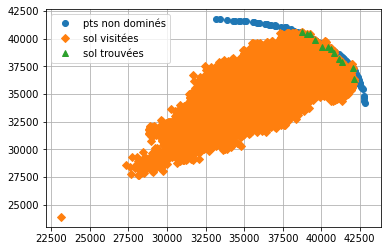

In [11]:
#affichage pour 2 critères + comparaison avec fichier .eff
import matplotlib.pyplot as plt

def readFile_EFF(fileName):
    points = []
    with open(fileName, "r") as txt_file:
        fichier = txt_file.readlines()
        tmp = []
        for ligne in fichier:
            tmp = ligne.split()
            points.append((int(tmp[0]), int(tmp[1])))
    return points

points = readFile_EFF("InstancesMOKP/100_items/2KP100-TA-0.eff")

res, sol_visitees = pls(Pzero, objs, tailleS)

liste_solutions = getPoints_2(objs, res)
solution_init = getPoints_2(objs, Pzero)
liste_solvisitees = getPoints_2(objs, sol_visitees)

    
plt.plot([i[0] for i in points],[i[1] for i in points], marker='o', linestyle="None", label='pts non dominés')
plt.plot([i[0] for i in liste_solvisitees],[i[1] for i in liste_solvisitees], marker='D', linestyle="None", label='sol visitées')
# plt.plot([i[0] for i in solution_init],[i[1] for i in solution_init], marker='s', linestyle="None", label='sol init')
plt.plot([i[0] for i in liste_solutions],[i[1] for i in liste_solutions], marker='^', linestyle="None", label='sol trouvées')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
Pzero = alea_pop(objs, tailleS)
objs, tailleS = readFile_DAT("2KP200-TA-0.dat", 20, 3)
res, sol_visitees = pls(Pzero, objs, tailleS)
#print(str(len(res)))
#print(str(len(sol_visitees)))

In [ ]:
#affichage pour 3 critères
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# from IPython.display import HTML
# from matplotlib import animation
# Writer = animation.writers['pillow']
# writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

liste_solutions = getPoints(objs, res)
# solution_init = getPoints(objs, Pzero)
liste_solvisitees = getPoints(objs, sol_visitees)

x = [i[0] for i in liste_solvisitees]
y = [i[1] for i in liste_solvisitees]
z = [i[2] for i in liste_solvisitees]

ax.scatter(xs = x, ys = y, zs = z, label="solutions visitées", marker="x", c="orange")

x = [i[0] for i in liste_solutions]
y = [i[1] for i in liste_solutions]
z = [i[2] for i in liste_solutions]

ax.scatter(xs = x, ys = y, zs = z, label="solutions trouvées", c="black")
    
ax.set_xlabel("critère 1")
ax.set_ylabel("critère 2")
ax.set_zlabel("critère 3")

ax.legend(loc="best")

plt.show()

# def animate(frame):
#     ax.view_init(30, frame/4)
#     plt.pause(.001)
#     return fig

# anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
# HTML(anim.to_html5_video())

# PLS et élicitation incrémentale

In [12]:
import random
import numpy as np
import copy
import quadtree as quadtree
import importlib
importlib.reload(quadtree)

def pls_EI(P0, objets, tailleSAD):
    """ Application du PLS à un problème SAD pour l'élicitation incrémentale

    Parametres
    ----------
    P0 : liste
        Population initiale
    objets : liste
        données des objets
    tailleSAD : int
        capacité W du SAD
        
    Returns
    -------
    X : liste
        racine du Quad-tree
    Y : liste
        évaluation des solutions de X
    """  
    #initialisation de la racine avec la population initiale (qui ne contient qu'une solution)
    racine = quadtree.Noeud(P0[0], somme_criteres(P0[0], objets))
    #len(objets[0])-1 correspond au nombre de critères
    XE = quadtree.QuadTree(len(objets[0])-1, racine)
    Pop = P0
    Pa = []
    solutions_deja_visitees = []
    while Pop != []:
        for p in Pop:
            for p_prim in voisinage(solutions_deja_visitees, p, objets, tailleSAD):
                solutions_deja_visitees.append(p_prim)
                if not est_domine_par(objets, p_prim, p):
                    maj_res1, XE = maj_quadtree(objets, XE, p_prim)
                    if maj_res1:
                        Pa.append(p_prim)
                        #maj_res2, Pa = maj(objets, Pa, p_prim) #mise à jour sans quadtree
            solutions_deja_visitees.append(p)
        Pop = Pa.copy()
        Pa = []
        
    X = [set(XE.racine.solution)] # solution avec des 0 et 1
    Y = [somme_criteres(XE.racine.solution, objets)] # évaluation de la solution (point correspondant)
    
    for noeud in XE.noeuds:
        X.append(noeud.solution)
        Y.append(noeud.v)
    
    return X, Y

def quadtree_to_liste_solutions (tree):
    """ Conversion d'un Quad-tree en liste

    Parametres
    ----------
    tree : Quad-tree

    Returns
    -------
    liste_pts : liste
    """ 
    liste_noeuds = tree.get_branch(tree.racine)
    liste_pts = []
    for i in liste_noeuds:
        liste_pts.append(i.solution)
    return liste_pts

def somme_criteres(v, objets):
    """ Evaluation d'une solution

    Parametres
    ----------
    v : int
        nb de critères
    objets : liste
        
    Returns
    -------
    v_critères : liste
    """ 
    v_criteres = [0] * (len(objets[0])-1)
    for i in range(len(v)):
        if v[i] == 1:
            for j in range(len(v_criteres)):
                v_criteres[j] += objets[i][j+1]
    return v_criteres
            

def alea_pop(objets, tailleSAD):
    """ Génération population aléatoire

    Parametres
    ----------
    objets : liste
    tailleSAD : int
        
    Returns
    -------
    [pop] : liste
    """ 
    pop = [0]*len(objets)
    capacite = tailleSAD
    tmp = 0
    
    while capacite > 0:
       #objets qu'on peut encore prendre ds le sac
            objets_restants = []
            for i in range(len(objets)):
                if (capacite - objets[i][0]) >=0:
                    objets_restants.append(objets[i])
                else:
                    break
                    
            if objets_restants == []:
                break    
                
            tmp = random.randint(0,len(objets_restants)-1)
         
            if (capacite - objets_restants[tmp][0]) >= 0:
                pop[tmp] = 1
                capacite -= objets_restants[tmp][0]       
    return [pop]

def objet_alea(x, objets, capacite):
    """ Renvoie un objet aléatoire qui peut rentrer dans le SAD

    Parametres
    ----------
    x : liste
        objets déjà pris
    objets : liste
    capacite : int
    
    Returns
    -------
    int
        
    """
    echantillon = []
    for o in range(len(objets)):
        if x[o] != 1 and objets[o][0] <= capacite:
            echantillon.append(o)
    if(echantillon == []):
        return -1
    return random.choice(echantillon)

def poidsSAD(objets, x):
    """ Renvoie le poids du SAD

    Parametres
    ----------
    objets : liste
    x : liste
        objets dans le SAD
    Returns
    -------
    int
        poids du SAD
    """
    poids = [i[0] for i in objets]
    return np.dot(x, poids)

def voisinage(solutions_deja_visitees, x, objets, capacite):
    """ Renvoie les voisins d'un solution

    Parametres
    ----------
    solutions_deja_visitees : liste
    x : liste
        une solution du SAD
    objets : liste
    capacite : liste
    
    Returns
    -------
    int
        poids du SAD
    """
    voisins = []
    for i in range(len(x)):
        xtmp = x.copy()
        if(x[i] == 1):
            xtmp[i] = 0
            poidsrestant = capacite - poidsSAD(objets, xtmp)
            alea = objet_alea(xtmp, objets, poidsrestant)
            while(alea != -1):
                poidsrestant = capacite - poidsSAD(objets, xtmp)
                alea = objet_alea(xtmp, objets, poidsrestant)
                xtmp[alea] = 1
            if xtmp not in solutions_deja_visitees:
                voisins.append(xtmp)
    return voisins

def est_domine_par(objets, p, p_prim):
    """ Renvoie true si p domine p_prim

    Parametres
    ----------
    objets : liste
    p : liste
        une solution du SAD
    p_prim : liste
        une solution du SAD
    
    Returns
    -------
    bool
    """    
    p_criteres = somme_criteres(p, objets)
    p_prim_criteres = somme_criteres(p_prim, objets)
 
    for i in range(len(p_criteres)):
        if(p_criteres[i] > p_prim_criteres[i]):
            return False

    return True

#mise à jour sans quadtree
# def maj(objets, solutions, solution):
#     solutionsdominees = []
#     solution_ajoutee = True
#     for x in solutions:
#         if est_domine_par(objets, solution, x):
#             return False, solutions
#         elif est_domine_par(objets, x, solution):
#             solutionsdominees.append(x)
            
#     tmpsol = solutions.copy()
    
#     for x in solutions:
#         if x in solutionsdominees:
#             tmpsol.remove(x)
        
#     if solution_ajoutee:
#         tmpsol.append(solution)
        
#     return solution_ajoutee, tmpsol

def maj_quadtree(objets, tree, solution):
    """ Ajoute une nouvelle solution dans le Quad-tree

    Parametres
    ----------
    objets : liste
    tree : Quad-tree
    solution : liste
    
    Returns
    -------
    solution_ajoutee : liste
    tmpsol : Quad-tree
        Quad-tree contenant la nouvelle solution
    """
    tmpsol = copy.deepcopy(tree)
    v = somme_criteres(solution, objets)
    n = quadtree.Noeud(solution, v)
    solution_ajoutee = tmpsol.inserer(n)
    #print(solution_ajoutee)    
    return solution_ajoutee, tmpsol

In [13]:
import fonctions_agregation as fonctions
importlib.reload(fonctions)

def solution_optimale(objets, tailleSAD, vecteur_poids, f_agregation = fonctions.SP, f_PMR = fonctions.PMR_SP):
    """ Solution optimale pour le décideur
    Application du PLS puis élicitation incrémentale avec somme pondérée
    
    Parametres
    ----------
    f_agregation : fonction
        fonction d'aggregation
    f_PMR: fonction
        programmation lineaire de pmr pour somme pondérée
    
    Returns
    -------
    nb_questions : int
        nombre de questions posées
    sol_opt :
        solution optimale selon le décideur
    sp_x : int
        
    liste_mmr : list
        liste MMR à chaque question
    """
    P0 = alea_pop(objets, tailleSAD)
    X, Y = pls_EI(P0, objets, tailleSAD)
    
    P = []
    x, mmr = fonctions.MMR(Y,P)
    y, mr = fonctions.MR(x, Y, P)
    liste_mmr = [mmr]
    
    nb_questions = 0
    
    # On continue à poser des questions tant qu'il y a du regret
    while mmr > 0:
        if fonctions.x_domine_y(x, y, vecteur_poids):
            P.append((x, y))
            i = np.where(np.array(Y) == y)[0][0]
            del Y[i]
            del X[i]
        else:
            P.append((y, x))
            i = np.where(np.array(Y) == x)[0][0]
            del Y[i]
            del X[i]
            
        x, mmr = fonctions.MMR(Y, P)
        y, mr = fonctions.MR(x, Y, P)
        
        nb_questions += 1
        liste_mmr.append(mmr)
        
    sol_opt = []
    
    for j in range(len(Y)):
        if np.all(x == Y[j]):
            sol_opt = X[j]
    
    sp_x = f_agregation(vecteur_poids, x)
    
    return nb_questions, sol_opt, sp_x, liste_mmr

In [14]:
import time

# génération aléatoire de poids sommant à 1 pour SP avec taille = taille de vecteur poids
def generer_poids(taille):
    poids = np.zeros(taille)
    somme = 1

    for i in range(taille-1):
        rnd = np.random.random()

        while sum(poids) + rnd > 1:
            rnd = np.random.random()
          
        poids[i] = rnd
        somme = somme - poids[i]

    poids[-1] = 1 - np.sum(poids)
    return poids

In [19]:
# test de la somme pondérée
objs, tailleS = readFile_DAT("2KP200-TA-0.dat", 20, 3)
start = time.time()
nb_questions, sol_opt, sp_y, liste_mmr = solution_optimale(objs, tailleS, generer_poids(len(objs[0])-1), fonctions.SP, f_PMR = fonctions.PMR_SP)
end = time.time()

print("nb questions = " + str(nb_questions))
print("a fini en " + str(end-start) + " secondes")
print("Solution optimale : ", sol_opt)
print("Résultat somme pondérée: ", sp_y)
print(liste_mmr)

nb questions = 4
a fini en 1.4037253856658936 secondes
Solution optimale :  [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1]
Résultat somme pondérée:  7003.868106652807
[599.0, 459.0, 238.83888048411498, 158.5752785990448, -30.20038657155257]


In [ ]:
def nb_questions_sol_opt(nb_essais, objs, tailleS):
    """ Donne le nombre de questions pour nb_essais
    """
    liste_nb_questions = [0]*10
    liste_temps = [0]*100
    
    for i in range(nb_essais-1):
        start = time.time()
        nb_questions, sol_opt, sp_y, liste_mmr = solution_optimale(objs, tailleS, generer_poids(len(objs[0])-1), fonctions.SP, f_PMR = fonctions.PMR_SP)
        liste_nb_questions[nb_questions] += 1
        end = time.time()
        liste_temps[nb_essais-1] = end-start
        
    return liste_nb_questions, liste_temps

In [ ]:
objs, tailleS = readFile_DAT("2KP200-TA-0.dat", 20, 3)
liste_nb_questions,liste_temps = nb_questions_sol_opt(100, objs, tailleS)

print(np.mean(liste_temps))

courses = list(range(0,10))
values = liste_nb_questions
fig = plt.figure(figsize = (10, 5))

plt.bar(courses, values, color ='blue', width = 0.5)

plt.xlabel("Nb de questions")
plt.ylabel("Nb d'expériences")
plt.title("Nb de questions posées pour 100 expériences")
plt.show()